### Question 2: Image Classification using CNN in Pytorch (70 points)

#### Importing necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

#### (a) Dataloader: Download the MNIST train and test dataset on Canvas. Implement a data loader with batch size and validation size as arguments.

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, images_path: str, labels_path: str, transform=None):
        self.image_data = torch.from_numpy(np.load(images_path)).float()
        self.labels_data = torch.from_numpy(np.load(labels_path)).long()

        length = len(self.image_data[0])
        dim = int(np.sqrt(length))
        self.image_data = self.image_data.reshape(-1, dim, dim)

        self.transform = transform

    def __len__(self):
        return len(self.labels_data)

    def __getitem__(self, idx):
        img = self.image_data[idx]
        label = self.labels_data[idx]

        img = img.numpy()

        if self.transform:
            img = self.transform(img)
        return img, label

I implemented a custom PyTorch dataset class called CustomImageDataset to efficiently load and preprocess the MNIST dataset. In the init method, I load the image and label data from numpy files. I then reshape the image data into a suitable format (height, width) using numpy operations. This preprocessing step ensures that the data is in the correct format for training deep learning models.

In [4]:
custom_tf = transforms.Compose([transforms.ToTensor()])

x_train_path = '/content/drive/MyDrive/x_train.npy'
y_train_path = '/content/drive/MyDrive/y_train.npy'
custom_dataset = CustomImageDataset(x_train_path, y_train_path, transform=custom_tf)

This creates a CustomImageDataset object that can be used to efficiently load and preprocess the MNIST training data, applying the ToTensor transformation to each image.

In [5]:
def data_loader(train_data: CustomImageDataset, batch_size: int, validation_split: float):
    """
    Create DataLoader objects for training and validation datasets with a specified validation split.
    """
    dataset_size = len(train_data)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split*dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    #Create DataLoader objects for training and validation datasets using the samplers
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size,sampler=train_sampler)
    val_loader = DataLoader(dataset=train_data, batch_size=batch_size, sampler=val_sampler)

    return train_loader, val_loader

I implemented the data_loader function to split the input dataset into training and validation subsets using a validation_split ratio. I randomly shuffled the dataset indices and created SubsetRandomSampler objects for the training and validation indices. These samplers were then used to instantiate separate DataLoader objects based on the batch_size for training and validation, ensuring the model is exposed to unseen data during validation for accurate performance evaluation.

In [6]:
# Batch size and validation split
batch_size =32
validation_split = 0.2

train_loader, val_loader = data_loader(custom_dataset, batch_size, validation_split)

This code snippet initializes train_loader and val_loader using DataLoader class, with a batch size of 32 and a validation split of 20%, based on the custom_dataset. DataLoader is an iterable that retrieves our dataset's features and label one sample at a time.

In [7]:
for image, label in train_loader:
    # Print the shape of one batch of images and labels
    print(f"Shape of one batch of images is,  {image.shape = }")
    print(f"Shape of one batch of labels is,  {label.shape = }")
    break

Shape of one batch of images is,  image.shape = torch.Size([32, 1, 28, 28])
Shape of one batch of labels is,  label.shape = torch.Size([32])


#### (b) Data Exploration Pick one example from each digit and visualize them. Count the number of samples per digit in the original training data. Is the data distribution balanced?

In [8]:
def visualize(dataset):
    """
    Visualize one sample image for each digit (0-9) in the dataset.
    """
    # Initialize a dictionary to store one sample image for each digit (0-9)
    digit_samples = {}
    for i in range(10):
        digit_samples[i] = None

    # Loop through the dataset to find one sample image for each digit
    for x, y in dataset:
        idx = y.item()
        if digit_samples[idx] is None:
            digit_samples[idx] = x

    fig, axes = plt.subplots(nrows = 1, ncols = 10, figsize=(15, 5))

    # Loop through the stored sample images for each digit and display them
    for i, (digit, image) in enumerate(digit_samples.items()):
        axes[i].imshow(image[0], cmap ="gray")
        axes[i].set_title(f'Digit {digit}')
        axes[i].axis('off')

    plt.show()


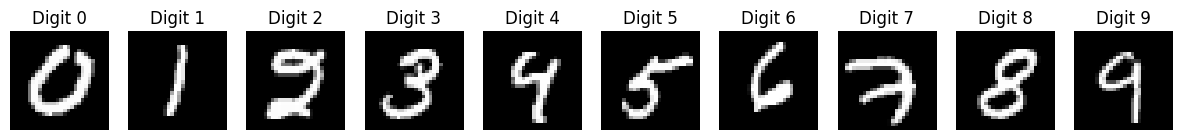

In [9]:
#visualising one example from each digit
visualize(custom_dataset)

In [10]:
def count_samples_per_digit(dataset):
    """
    Counts the number of samples for each digit (0-9) in the given dataset.
    """
    digit_counts = {i: 0 for i in range(10)}
    for _, y in dataset:
        digit_counts[y.item()] += 1
    return digit_counts

In [11]:
# Count samples per digit
digit_counts = count_samples_per_digit(custom_dataset)
print("Number of samples per digit:")
for digit, count in digit_counts.items():
    print(f"Digit {digit}: {count}")

Number of samples per digit:
Digit 0: 5923
Digit 1: 6742
Digit 2: 5958
Digit 3: 6131
Digit 4: 5842
Digit 5: 5421
Digit 6: 5918
Digit 7: 6265
Digit 8: 5851
Digit 9: 5949


##### The data distribution for the number of samples per digit in the original training data is not balanced. For example, I can see that digit 1 has the highest number of samples at 6742, while digit 5 has the lowest number of samples at 5421. This means that some digits are represented more than others in the training data, which could potentially lead to biases in the model's performance. A balanced distribution, where each digit has a similar number of samples, would be ideal for ensuring fair and accurate predictions across all digits.

#### (c) Data Split Split original training data into 80% for training and 20% validation datasets.

This step has already been completed in part a) through data_loader function.

#### (d) Modeling Implement a convolutional neural network to classify the digits in the MNIST dataset. Experiment with at least 3 hyperparameters. You may experiment with different CNN hyper-parameters, e.g. num of layers, filter size, stride, activation function, dropout, weight regularization, etc. Use the validation data to decide which combination of hyperparameters is best. Report the final classification accuracy on the validation dataset.

In [12]:
class CNN(nn.Module):
    def __init__(self, num_layers, kernel_size, dropout_rate):
        super(CNN, self).__init__()

        # Initialize the CNN with the provided parameters
        self.num_layers = num_layers
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate

        layers = []
        in_channels = 1

        # Define convolutional layers
        for i in range(self.num_layers):
            out_channels = 16*(2**i)

            # Each layer consists of Convolution, ReLU activation, MaxPooling, and Dropout
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=self.kernel_size, stride = 1, padding = self.kernel_size//2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout(self.dropout_rate)
            ))
            in_channels = out_channels #updated in_channels of next layer to match the out channels of previous layer

         # Group all convolutional layers into a sequential module
        self.conv_layers = nn.Sequential(*layers)

        # Calculate the size of the image after convolutional layers
        image_size = 28
        for _ in range(self.num_layers):
            pad = self.kernel_size//2
            image_size = (image_size - self.kernel_size + 2*pad) + 1 #stride = 1 so no contribution in formula
            image_size = image_size // 2 #since I am not using any stride in MaxPool2d

        # Define fully connected layers
        self.fc1 = nn.Linear(out_channels * image_size * image_size, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(self.dropout_rate)
        self.relu = nn.ReLU()


    def forward(self, x):
        # Forward pass through the network

        # print(x.shape)
        x = self.conv_layers(x) # Convolutional layers
        # print(x.shape)
        x = torch.flatten(x, 1) # Flatten the output of convolutional layers for fully connected layers
        # print(x.shape)


        #Fully connected layers
        x = self.fc1(x)
        # print(x.shape)
        x = self.relu(x)
        # print(x.shape)
        x = self.dropout(x)
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)

        return x

This Convolutional Neural Network (CNN) is designed with keeping flexibility in mind. The number of convolutional layers, kernel size, and dropout rate are customizable parameters. The network begins with a series of convolutional layers, each followed by ReLU activation, max-pooling, and dropout for regularization. These layers help extract hierarchical features from the input images. After the convolutional layers, the feature maps are flattened and fed into two fully connected layers with 128 and 10 neurons respectively, followed by ReLU activation and dropout. The final layer produces logits for classification. Overall, this architecture aims to efficiently learn and represent features from image data while mitigating overfitting through dropout regularization.

In [13]:
model = CNN(num_layers = 2, kernel_size = 3, dropout_rate = 0.25)
model

CNN(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.25, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.25, inplace=False)
    )
  )
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)

In [14]:
#testing model for a random sample of the same shape as out training data in batches
test_sensor = torch.randn(32, 1, 28, 28)
a = model(test_sensor)
print(f"{a.shape = }")

a.shape = torch.Size([32, 10])


In [15]:
def train_epoch(model: CNN, train_loader: DataLoader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    """
    model.train()  #Set the model to training mode
    train_loss = 0
    correct = 0
    total = 0

    #Iterate over the training data
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        #Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels) #Calculate the loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward() #Backpropagation
        optimizer.step()

        train_loss += loss.item() #Updatetraining loss

        #calculate accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return avg_train_loss, train_accuracy

Here, I wrote a function to train the model for one epoch.

In [16]:
def evaluate_model(model, val_loader, criterion, device):
    """
    Evaluate the model on the validation dataset
    """
    model.eval()  #Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) #move inputs and labels to either CPU or GPU

            outputs = model(inputs) #Forward pass
            loss = criterion(outputs, labels) #Calculate the loss
            val_loss += loss.item()

            #calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    #Calculate average validation loss and validation accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return avg_val_loss, val_accuracy

This function is used to evaluate the model on the validation set.

In [17]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    """
    Train the model for a specified number of epochs and evaluate it on the validation dataset.
    """
    #Determine the device (CPU or GPU) for computations
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    model = model.to(device) #move the model to appropriate device

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []

    for epoch in range(num_epochs):
        avg_train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device) #model training
        avg_val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device) #model evaluation

        training_loss.append(avg_train_loss)
        training_accuracy.append(train_accuracy)
        validation_loss.append(avg_val_loss)
        validation_accuracy.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Return the trained model and the lists of training and validation metrics
    return model, (training_loss, validation_loss, training_accuracy, validation_accuracy)


This function combines the functionalities of train_epoch and evaluate_model and train the model for a specified number of epochs and evaluate it on the validation dataset.

In [18]:
conv_layers_list = [1, 2, 3]
kernel_list = [3, 5, 7]
dropout_list = [0.25, 0.50, 0.75]

Below given code trains the model on different hyperparameters mentioned in above line of code and throws out the best_trained_model, best accuracy and best parameters of the trained model

In [19]:
best_overall_accuracy = 0
best_params = {}
best_overall_model = None
# Iterate over each combination of parameters
for num_layers in conv_layers_list:
    for kernel_size in kernel_list:
        for dropout_rate in dropout_list:
            model = CNN(num_layers=num_layers, kernel_size=kernel_size, dropout_rate=dropout_rate)
            print(f"Training model with {num_layers} layers, kernel size {kernel_size}, dropout rate {dropout_rate}")
            trained_model, (training_loss, validation_loss, training_accuracy, validation_accuracy) = train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)

            val_accuracy = validation_accuracy[-1]

            # Compare the maximum validation accuracy with the best overall accuracy
            if val_accuracy > best_overall_accuracy:
                best_overall_accuracy = val_accuracy
                best_overall_model = trained_model
                best_params = {'num_layers': num_layers, 'kernel_size': kernel_size, 'dropout_rate': dropout_rate}

print(f"Best Model Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_overall_accuracy:.2f}%")

Training model with 1 layers, kernel size 3, dropout rate 0.25
Training on device: cuda
Epoch 1/10, Training Loss: 0.3351, Training Accuracy: 89.83%, Validation Loss: 0.1258, Validation Accuracy: 96.25%
Epoch 2/10, Training Loss: 0.1261, Training Accuracy: 96.21%, Validation Loss: 0.0735, Validation Accuracy: 97.69%
Epoch 3/10, Training Loss: 0.0941, Training Accuracy: 97.11%, Validation Loss: 0.0614, Validation Accuracy: 98.01%
Epoch 4/10, Training Loss: 0.0771, Training Accuracy: 97.64%, Validation Loss: 0.0610, Validation Accuracy: 97.98%
Epoch 5/10, Training Loss: 0.0666, Training Accuracy: 97.85%, Validation Loss: 0.0549, Validation Accuracy: 98.21%
Epoch 6/10, Training Loss: 0.0570, Training Accuracy: 98.26%, Validation Loss: 0.0544, Validation Accuracy: 98.36%
Epoch 7/10, Training Loss: 0.0500, Training Accuracy: 98.37%, Validation Loss: 0.0573, Validation Accuracy: 98.24%
Epoch 8/10, Training Loss: 0.0470, Training Accuracy: 98.54%, Validation Loss: 0.0487, Validation Accuracy:

In [20]:
print(f"Best Model Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_overall_accuracy:.2f}%")

Best Model Parameters: {'num_layers': 3, 'kernel_size': 3, 'dropout_rate': 0.25}
Best Validation Accuracy: 99.12%


#### (g) Inference Use the best fine-tuned model for inference on the test dataset. Save your predictions for every row of the test data in a CSV file with the name FirstName LastName Preds.csv (Do not shuffle the test data)

In [21]:
class CustomTestDataset(Dataset):
    def __init__(self, images_path: str, transform=None):
        self.image_data = torch.from_numpy(np.load(images_path)).float()
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img = self.image_data[idx]
        img = img.numpy()

        if self.transform:
            img = self.transform(img)
        return img

Implemented a custom PyTorch dataset class called CustomTestDataSet to efficiently load Test MNIST dataset. In the init method, I load the test images from numpy files.

In [29]:
x_test_path = '/content/drive/MyDrive/x_test.npy'
custom_test_dataset = CustomTestDataset(x_test_path, transform= custom_tf)
test_loader = DataLoader(custom_test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
def predict(trained_model: CNN, test_data: DataLoader):
    """
    Generate predictions using a trained CNN model on the test dataset.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    trained_model = trained_model.to(device)

    trained_model.eval() #set the model to evaluation mode
    predictions = []
    with torch.no_grad():
        for inputs in test_data:
            inputs= inputs.to(device)
            outputs = trained_model(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().tolist())
    return predictions

In [31]:
predictions = predict(trained_model, test_loader)
pred_np = np.array(predictions)
pred_1d = pred_np.reshape(pred_np.shape[0],)
predictions_df = pd.DataFrame({'pred_cnn': pred_1d})
predictions_df.to_csv('Jasdeep_Bajaj_preds.csv', index=False)

Training on device: cuda


##### BONUS(+10 points): Filter Visualization Randomly pick an image from the training set. Visualize the feature maps corresponding to all convolution filters after the first and last convolution layers

In [32]:
activations = []
def get_activations(self, input, output):
    activations.append(output.detach().cpu())

# First convolutional layer
first_conv_layer = trained_model.conv_layers[0][0].register_forward_hook(get_activations)
# Last convolutional layer
last_conv_layer = model.conv_layers[-1][0].register_forward_hook(get_activations)

Defined a hook function here that will be called after the forward pass of the desired layer, and it will store the feature maps (activations) for visualization and registered the hook function to the desired convolutional layers in my trained model.

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
random_idx = np.random.randint(len(custom_dataset))
input_image, _ = custom_dataset[random_idx]
input_image = input_image.to(device)
trained_model.eval()
output = trained_model(input_image.unsqueeze(0))

Getting a random image and forward pass it to the trained model to view feature images after each convolutional layer

In [39]:
digit = output.argmax().item()

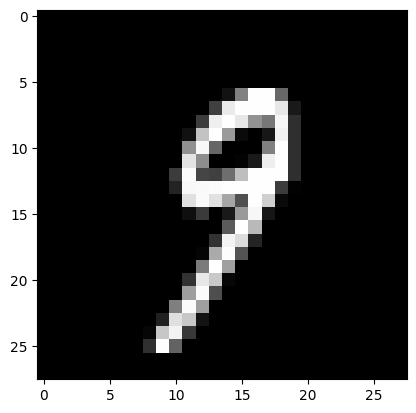

In [40]:
input_image = input_image.cpu()
plt.imshow(input_image[0], cmap='gray') #the actual random image

Plotting the actual random image which is used to pass through the trained model i.e. input to the model

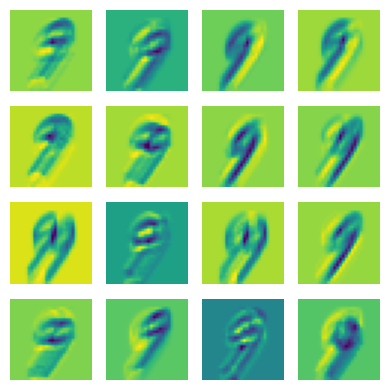

In [41]:
# Visualize feature maps after the first convolutional layer
first_conv_activations = activations[1].squeeze()
num_channels = first_conv_activations.shape[0]

nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4, 4))

# Iterate over the subplots and display the feature maps
for i, ax in enumerate(axs.flat):
    if i < num_channels:
        ax.imshow(first_conv_activations[i])
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

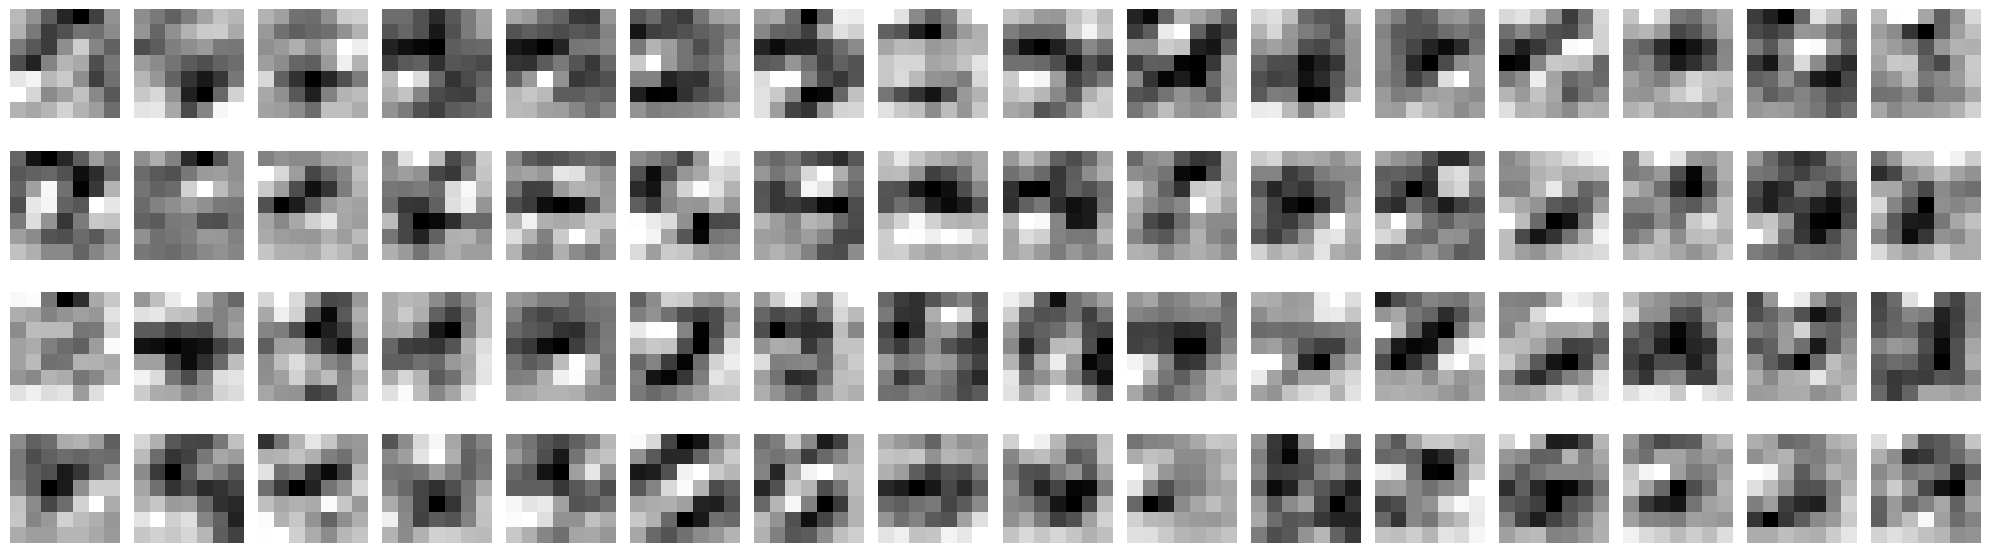

In [42]:
# Visualize feature maps after the last convolutional layer
last_conv_activations = activations[-1].squeeze()
num_channels = last_conv_activations.shape[0]

nrows, ncols = 4, 16
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 6))

for i, ax in enumerate(axs.flat):
    if i < num_channels:
        ax.imshow(last_conv_activations[i], cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

Here I Visualize the feature maps after first and last convolutional layers

In [43]:
first_conv_layer.remove()
last_conv_layer.remove()

Removing the hooks after visualizing the feature maps to prevent memory leaks